Processing folder: CFedDC_rl1_C2
Processing folder: CFedDC_rl1_C3
Processing folder: CFedDC_rl1_C4
Processing folder: CFedDC_rl1_C5
Processing folder: CFedDC_rl1_C10
Processing folder: CFedDC_rl1_C15
Common rounds across folders: 30
Plotting full range: 30 rounds


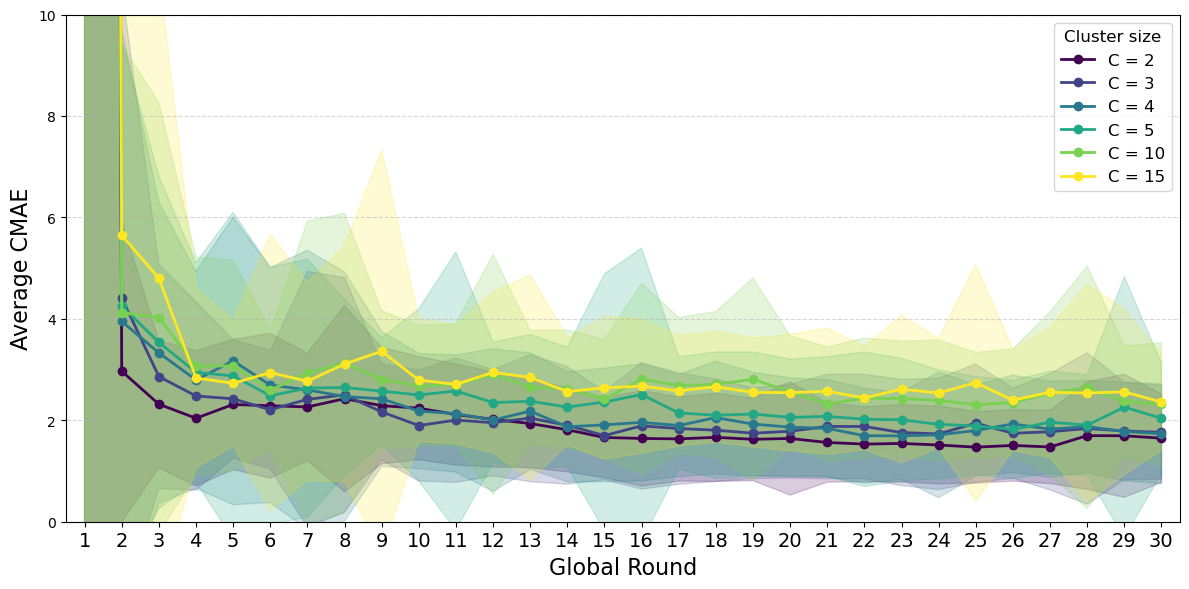

Saved cluster‐comparison plot at:
    /proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level/all_mae/resourceful_cluster_2_to_15.png


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ─── CONFIGURATION ────────────────────────────────────────────────────────────
base_dir  = "/proj/sourasb-220503/TCSS-DIPA2/Fed-DIPA2/results/client_level"

folders   = [
    "CFedDC_KT_RL_rl1_C2",
    "CFedDC_rl1_C3",
    "CFedDC_rl1_C4",
    "CFedDC_rl1_C5",
    "CFedDC_rl1_C10",
    "CFedDC_rl1_C15",
]


num_users = 535

# ─── STEP 1: COLLECT DATA ──────────────────────────────────────────────────────
cmae_lists = { folder: [] for folder in folders }

for folder in folders:
    print(f"Processing folder: {folder}")
    for user_id in range(num_users):
        filename = f"user_{user_id}_test_round_results.json"
        file_path = os.path.join(base_dir, folder, "local_test", filename)

        if not os.path.exists(file_path):
            continue

        try:
            with open(file_path, "r") as f:
                data = json.load(f)
        except Exception as e:
            print(f"[Warning] Could not read {file_path}: {e}")
            continue

        # RESOURCELESS ONLY
        rc = data.get("resource_category", "Unknown").replace(" user", "").lower()
        if rc != "resourceful":
            continue

        cmae = data.get("validation_results", {}).get("info_cmae", [])
        if not cmae:
            continue

        cmae_lists[folder].append(cmae)

# ─── STEP 2: ORGANIZE DATA BY ROUND ────────────────────────────────────────────
for folder in folders:
    if len(cmae_lists[folder]) == 0:
        raise RuntimeError(f"No resourceful users found for {folder}.")

max_rounds_per_folder = [max(len(lst) for lst in cmae_lists[folder]) for folder in folders]
common_rounds = min(max_rounds_per_folder)
print(f"Common rounds across folders: {common_rounds}")

plot_rounds = min(common_rounds, 30)
print(f"Plotting full range: {plot_rounds} rounds")

by_round = {}
for folder in folders:
    by_round[folder] = [[] for _ in range(common_rounds)]
    for user_list in cmae_lists[folder]:
        for r in range(len(user_list)):
            if r < common_rounds:
                by_round[folder][r].append(user_list[r])

# ─── STEP 3: PLOT AVERAGE CMAE + STD SHADING (cluster comparison) ──────────
plt.figure(figsize=(12, 6))

rounds = np.arange(1, plot_rounds + 1)

# Viridis palette, one color per folder
cmap   = plt.get_cmap("viridis")
colors = [cmap(i/(len(folders)-1)) for i in range(len(folders))]

for idx, folder in enumerate(folders):
    avg_cmae = []
    std_cmae = []
    for r in range(plot_rounds):
        vals = by_round[folder][r]
        avg_cmae.append(np.mean(vals))
        std_cmae.append(np.std(vals))

    # find min round & value if you still want it
    # min_val   = np.min(avg_cmae)
    # min_round = np.argmin(avg_cmae) + 1

    # Extract cluster size from folder, e.g. "CFedDC_rl1_C10" → "10"
    cluster_size = folder.split('_')[-1].lstrip('C')
    label = f"C = {cluster_size}"

    # plot mean line
    plt.plot(
        rounds,
        avg_cmae,
        label=label,
        color=colors[idx],
        linewidth=2,
        marker='o', markersize=6
    )

    # shade ±1 std
    avg_cmae = np.array(avg_cmae)
    std_cmae = np.array(std_cmae)
    plt.fill_between(
        rounds,
        avg_cmae - std_cmae,
        avg_cmae + std_cmae,
        color=colors[idx],
        alpha=0.2
    )

# X‐axis ticks & limits
plt.xticks(rounds, rounds, fontsize=14)
plt.xlim(0.5, plot_rounds + 0.5)

# Labels, grid, legend
plt.xlabel("Global Round", fontsize=16)
plt.ylabel("Average CMAE",   fontsize=16)
plt.ylim(0.0, 10.0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(title="Cluster size", fontsize=12, title_fontsize=12, loc="upper right")
plt.tight_layout()

# Save & show
save_path = os.path.join(base_dir, "all_mae", "resourceful_cluster_2_to_15.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path)
plt.show()
plt.close()

print(f"Saved cluster‐comparison plot at:\n    {save_path}")


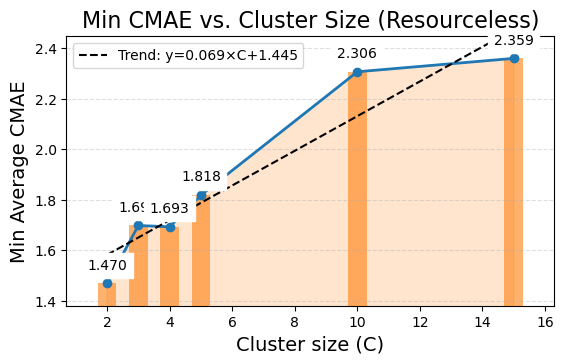

In [16]:
# ─── STEP 4: PLOT MIN CMAE VS CLUSTER SIZE WITH BAR, LINE & TREND ────────────

# (1) Build arrays keyed by cluster size
cluster_sizes = []
min_cmaes     = []

for folder in folders:
    # compute per-round averages up to plot_rounds
    avg_cmae = [np.mean(by_round[folder][r]) for r in range(plot_rounds)]
    if not avg_cmae:
        continue

    # extract the numeric C-value from "…_C10" etc
    size = int(folder.split("_")[-1].lstrip("C"))
    cluster_sizes.append(size)
    min_cmaes.append(min(avg_cmae))

# convert to NumPy and sort by cluster size
cluster_sizes = np.array(cluster_sizes)
min_cmaes     = np.array(min_cmaes)
order         = np.argsort(cluster_sizes)
cluster_sizes = cluster_sizes[order]
min_cmaes     = min_cmaes[order]

# (2) Fit trend if possible
if cluster_sizes.size > 1:
    coef  = np.polyfit(cluster_sizes, min_cmaes, deg=1)
    trend = np.poly1d(coef)
    x_fit = np.linspace(cluster_sizes.min(), cluster_sizes.max(), 100)
    y_fit = trend(x_fit)

fig, ax = plt.subplots(figsize=(6,4))

# (3) Bar chart of minima
bar_width = (cluster_sizes[1] - cluster_sizes[0]) * 0.6
ax.bar(cluster_sizes, min_cmaes,
       width=bar_width,
       color='C1', alpha=0.6)

# (4) Line connecting minima
ax.plot(cluster_sizes, min_cmaes,
        marker='o', color='C0', linewidth=2)

# (5) Shaded under the line
ax.fill_between(cluster_sizes, min_cmaes, 0,
                color='C1', alpha=0.2)

# (6) Trendline overlay
if cluster_sizes.size > 1:
    ax.plot(x_fit, y_fit,
            linestyle='--', color='black', linewidth=1.5,
            label=f"Trend: y={coef[0]:.3f}×C+{coef[1]:.3f}")

# (7) Axis padding
xmin, xmax = cluster_sizes.min(), cluster_sizes.max()
xpad = (xmax - xmin) * 0.1
ax.set_xlim(xmin - xpad, xmax + xpad)

ymin, ymax = min_cmaes.min(), min_cmaes.max()
ypad = (ymax - ymin) * 0.1
ax.set_ylim(ymin - ypad, ymax + ypad)

# (8) Annotations
for C, y in zip(cluster_sizes, min_cmaes):
    ax.annotate(f"{y:.3f}",
                xy=(C, y),
                xytext=(0, 8),
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=10,
                backgroundcolor='white',
                clip_on=False)

# (9) Final styling
ax.set_xlabel("Cluster size (C)", fontsize=14)
ax.set_ylabel("Min Average CMAE",   fontsize=14)
ax.set_title("Min CMAE vs. Cluster Size (Resourceless)", fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.4)
if cluster_sizes.size > 1:
    ax.legend(fontsize=10)
ax.margins(x=0, y=0.1)
plt.tight_layout(pad=2)

# (10) Save + show
out_file = os.path.join(base_dir, "all_mae", "min_cluster_analysis_resourceful.png")
os.makedirs(os.path.dirname(out_file), exist_ok=True)
plt.savefig(out_file)
plt.show()


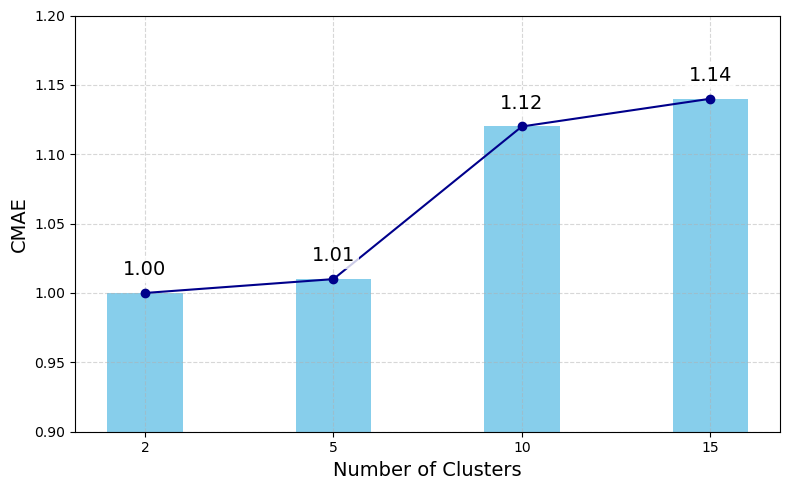

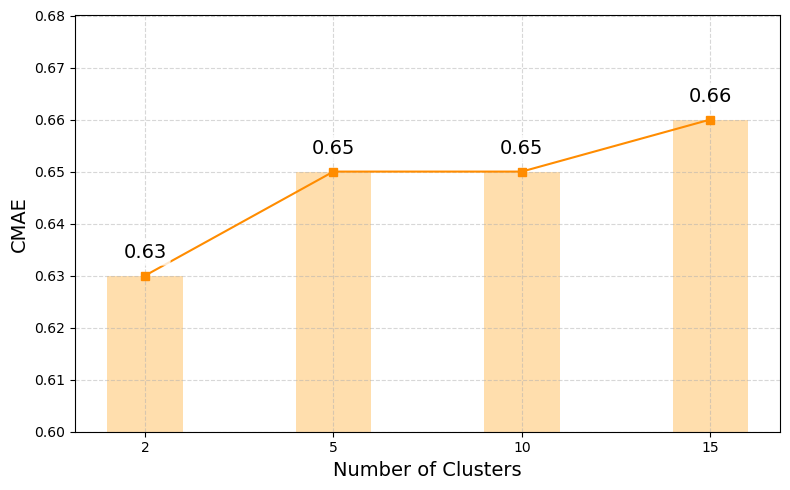

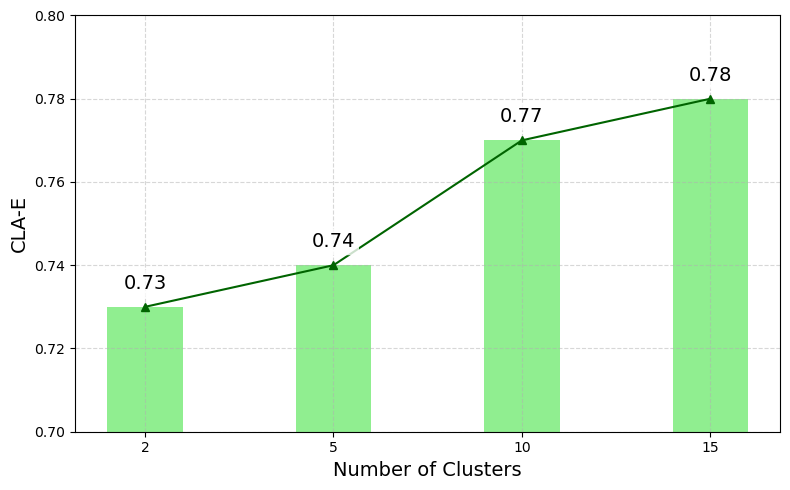

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the table
clusters = [2, 5, 10, 15]
cmae_rf = [1.00, 1.01, 1.12, 1.14]  # Resourceful
cmae_rl = [0.63, 0.65, 0.65, 0.66]  # Resourceless
clae_all = [0.73, 0.74, 0.77, 0.78]  # All clients

index = np.arange(len(clusters))
bar_width = 0.4

# ---------------- Resourceful Clients ----------------
fig1, ax1 = plt.subplots(figsize=(8, 5))

# Bar plot
bars_rf = ax1.bar(index, cmae_rf, bar_width, label='CMAE RF', color='skyblue')

# Line plot
ax1.plot(index, cmae_rf, color='darkblue', marker='o', linestyle='-', label='RF Line')

# Add numbers above bars with white background
for bar in bars_rf:
    height = bar.get_height()
    ax1.annotate(
        f'{height:.2f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 10),
        textcoords="offset points",
        ha='center', va='bottom',
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.2", edgecolor='none', facecolor='white', alpha=0.8)
    )

# Formatting
ax1.set_xlabel('Number of Clusters', fontsize=14)
ax1.set_ylabel('CMAE', fontsize=14)
ax1.set_ylim(0.9, 1.2)
ax1.set_xticks(index)
ax1.set_xticklabels(clusters)
ax1.grid(True, linestyle='--', alpha=0.5)
fig1.tight_layout()
fig1.savefig("cmae_rf_plot.png", dpi=300)

# ---------------- Resourceless Clients ----------------
fig2, ax2 = plt.subplots(figsize=(8, 5))

# Bar plot
bars_rl = ax2.bar(index, cmae_rl, bar_width, label='CMAE RL', color='navajowhite')

# Line plot
ax2.plot(index, cmae_rl, color='darkorange', marker='s', linestyle='-', label='RL Line')

# Add numbers above bars with white background
for bar in bars_rl:
    height = bar.get_height()
    ax2.annotate(
        f'{height:.2f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 10),
        textcoords="offset points",
        ha='center', va='bottom',
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.2", edgecolor='none', facecolor='white', alpha=0.8)
    )

# Formatting
ax2.set_xlabel('Number of Clusters', fontsize=14)
ax2.set_ylabel('CMAE', fontsize=14)
ax2.set_ylim(0.6, 0.68)
ax2.set_xticks(index)
ax2.set_xticklabels(clusters)
ax2.grid(True, linestyle='--', alpha=0.5)
fig2.tight_layout()
fig2.savefig("cmae_rl_plot.png", dpi=300)

plt.show()

# ---------------- All Clients ----------------
fig3, ax3 = plt.subplots(figsize=(8, 5))
# Bar plot
bars_all = ax3.bar(index, clae_all, bar_width, label='CLA-E All', color='lightgreen')
# Line plot
ax3.plot(index, clae_all, color='darkgreen', marker='^', linestyle='-', label='All Line')
# Add numbers above bars with white background
for bar in bars_all:
    height = bar.get_height()
    ax3.annotate(
        f'{height:.2f}',
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 10),
        textcoords="offset points",
        ha='center', va='bottom',
        fontsize=14,
        bbox=dict(boxstyle="round,pad=0.2", edgecolor='none', facecolor='white', alpha=0.8)
    )
# Formatting
ax3.set_xlabel('Number of Clusters', fontsize=14)
ax3.set_ylabel('CLA-E', fontsize=14)
ax3.set_ylim(0.7, 0.8)
ax3.set_xticks(index)
ax3.set_xticklabels(clusters)
ax3.grid(True, linestyle='--', alpha=0.5)
fig3.tight_layout()
fig3.savefig("clae_all_plot.png", dpi=300)
# Show all plots
plt.show()
